# Diabetic analysis & modeling
## 1. Exploratory Data Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("../data/diabetic_data.csv")

In [13]:
df.replace("?", np.nan, inplace=True)

In [29]:
df.shape

(101766, 50)

In [28]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [30]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

- There are 50 columns and more than 100k rows for the diabetic data
- The target label is **readmitted** which is category with 3 labels: 
    - "No": No readmission for inpatient
    - ">30": patient was readmitted in 30 days or more
    - "<30": patient was readmitted in less than 30 days
- There are total 48 input variables

In [176]:
df = df.drop(["encounter_id","patient_nbr"],axis=1)

### 1.1. Missing values & Imputation
#### 1.1.1. Missing values

In [20]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
missing_pct = missing_values / len(df) * 100


In [25]:
missing_pct.index

Index(['weight', 'medical_specialty', 'payer_code', 'race', 'diag_3', 'diag_2',
       'diag_1'],
      dtype='object')

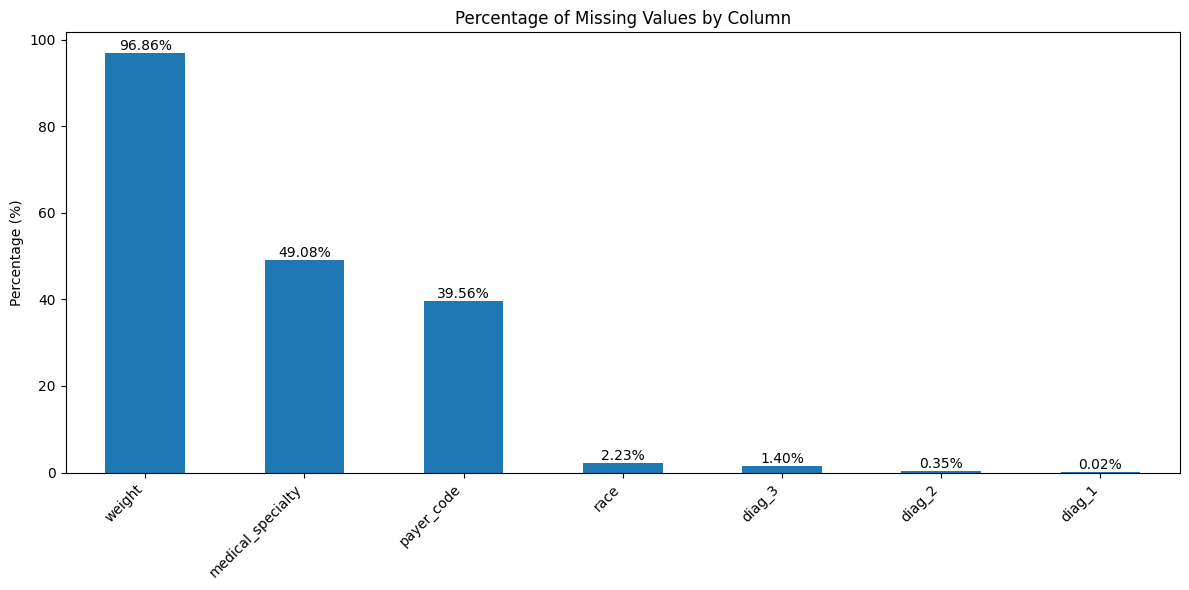

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
missing_pct.plot(kind='bar', ax=ax)
for idx,vals in enumerate(missing_pct):
    ax.text(idx, vals, f"{vals:.2f}%", ha='center', va='bottom')
ax.set_title('Percentage of Missing Values by Column')
ax.set_ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


In [68]:
df.medical_specialty.value_counts(normalize=True)*100

None                             49.082208
InternalMedicine                 14.381031
Emergency/Trauma                  7.433720
Family/GeneralPractice            7.310890
Cardiology                        5.259124
                                   ...    
SportsMedicine                    0.000983
Speech                            0.000983
Perinatology                      0.000983
Neurophysiology                   0.000983
Pediatrics-InfectiousDiseases     0.000983
Name: medical_specialty, Length: 73, dtype: float64

- Out of 48 input variables, 7 variables have missing values
- Weight is a numeric variable and has 97% missing value. Although it is important feature, but due to lots of missing values, we have to ignore this variable
- Medical_Specialty containts information for the treatment procedure. It has about 49% missing values. According to suggestion, we will convert the missing value to None and apply OHE to this.
- Similarly, we will apply the same for **payer_code** and **race**
- diag1, diag2, diag3 will be combined and imputed in the later part

#### 1.1.2. Imputations
- First remove **weight** column

In [33]:
df = df.drop(["weight"],axis=1)

- Next, impute **medical_specialty** with **None**
- To reduce the dimension of this variable, we merge all categorical with less than 1% occurrence to the new variable called **Rest**


In [69]:
df.medical_specialty.fillna("None",inplace=True)
small_specialty = df.medical_specialty.value_counts(normalize=True)*100
df.medical_specialty = df.medical_specialty.replace(small_specialty.index[small_specialty<=1].values,"Rest")

- Impute payer_code

In [74]:
df.payer_code.fillna("None",inplace=True)
small_pcode = df.payer_code.value_counts(normalize=True)*100
df.payer_code = df.payer_code.replace(small_pcode.index[small_pcode<=1].values,"Rest")

- Impute **race**
- We do not merge any other race for this varialbe due to very small amount of missing value

In [79]:
df.race.fillna("None",inplace=True)

- Impute **diag1, diag2, diag3**: replace Nan value with **None**
- For each diag category, retain the top 1% category value (~top 20 category), the rest convert to **Rest**
- Create new diag column with following criteria:
    - if there are values in diag_1, diag_2 and diag_3: get the value from diag_1 only
    - if there are values in diag_2 and diag_3 only: get the value from diag_2 only
- Keep only diag column and remove the rest    




In [83]:
df.diag_1.fillna("None",inplace=True)
df.diag_2.fillna("None",inplace=True)
df.diag_3.fillna("None",inplace=True)

In [127]:
ind1 = df.diag_1.value_counts(normalize=True)*100
df.diag_1 = df.diag_1.replace(ind1.index[ind1<=1].values,"Rest")

ind2 = df.diag_2.value_counts(normalize=True)*100
df.diag_2 = df.diag_2.replace(ind2.index[ind2<=1].values,"Rest")

ind3 = df.diag_3.value_counts(normalize=True)*100
df.diag_3 = df.diag_3.replace(ind3.index[ind3<=1].values,"Rest")

In [133]:
def pick_diag(row):
    for col in ['diag_1', 'diag_2', 'diag_3']:
        val = row[col]
        if pd.notna(val) and val != 'Rest' and val != 'None':
            return val
    return 'Rest'  # If all are "Rest" or None

# Apply to DataFrame
df['diag'] = df.apply(pick_diag, axis=1)

In [135]:
df = df.drop(["diag_1","diag_2","diag_3"],axis=1)

- Convert **age** from category to numeric

In [140]:
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
    '[80-90)': 85, '[90-100)': 95
}
df['age_mid'] = df['age'].map(age_map)
df = df.drop(["age"],axis=1)


- Convert max_glu_serum to continuos value

In [170]:
glu_map = {
    'None': 0, 'Norm': 1, '>200': 2, '>300': 3
    }
df['glu'] = df['max_glu_serum'].map(glu_map)
df = df.drop(["max_glu_serum"],axis=1)

- Similar impute for 'A1Cresult'

In [173]:
a1c_map = {
    'None': 0, 'Norm': 1, '>7': 7, '>8': 8
    }
df['A1C'] = df['A1Cresult'].map(a1c_map)
df = df.drop(["A1Cresult"],axis=1)

### 1.2. Catogorical and Numerical data analysis

In [186]:
cat_cols = df.select_dtypes("object").columns
df_cat = df[cat_cols]
df_num = df.drop(cat_cols,axis=1)

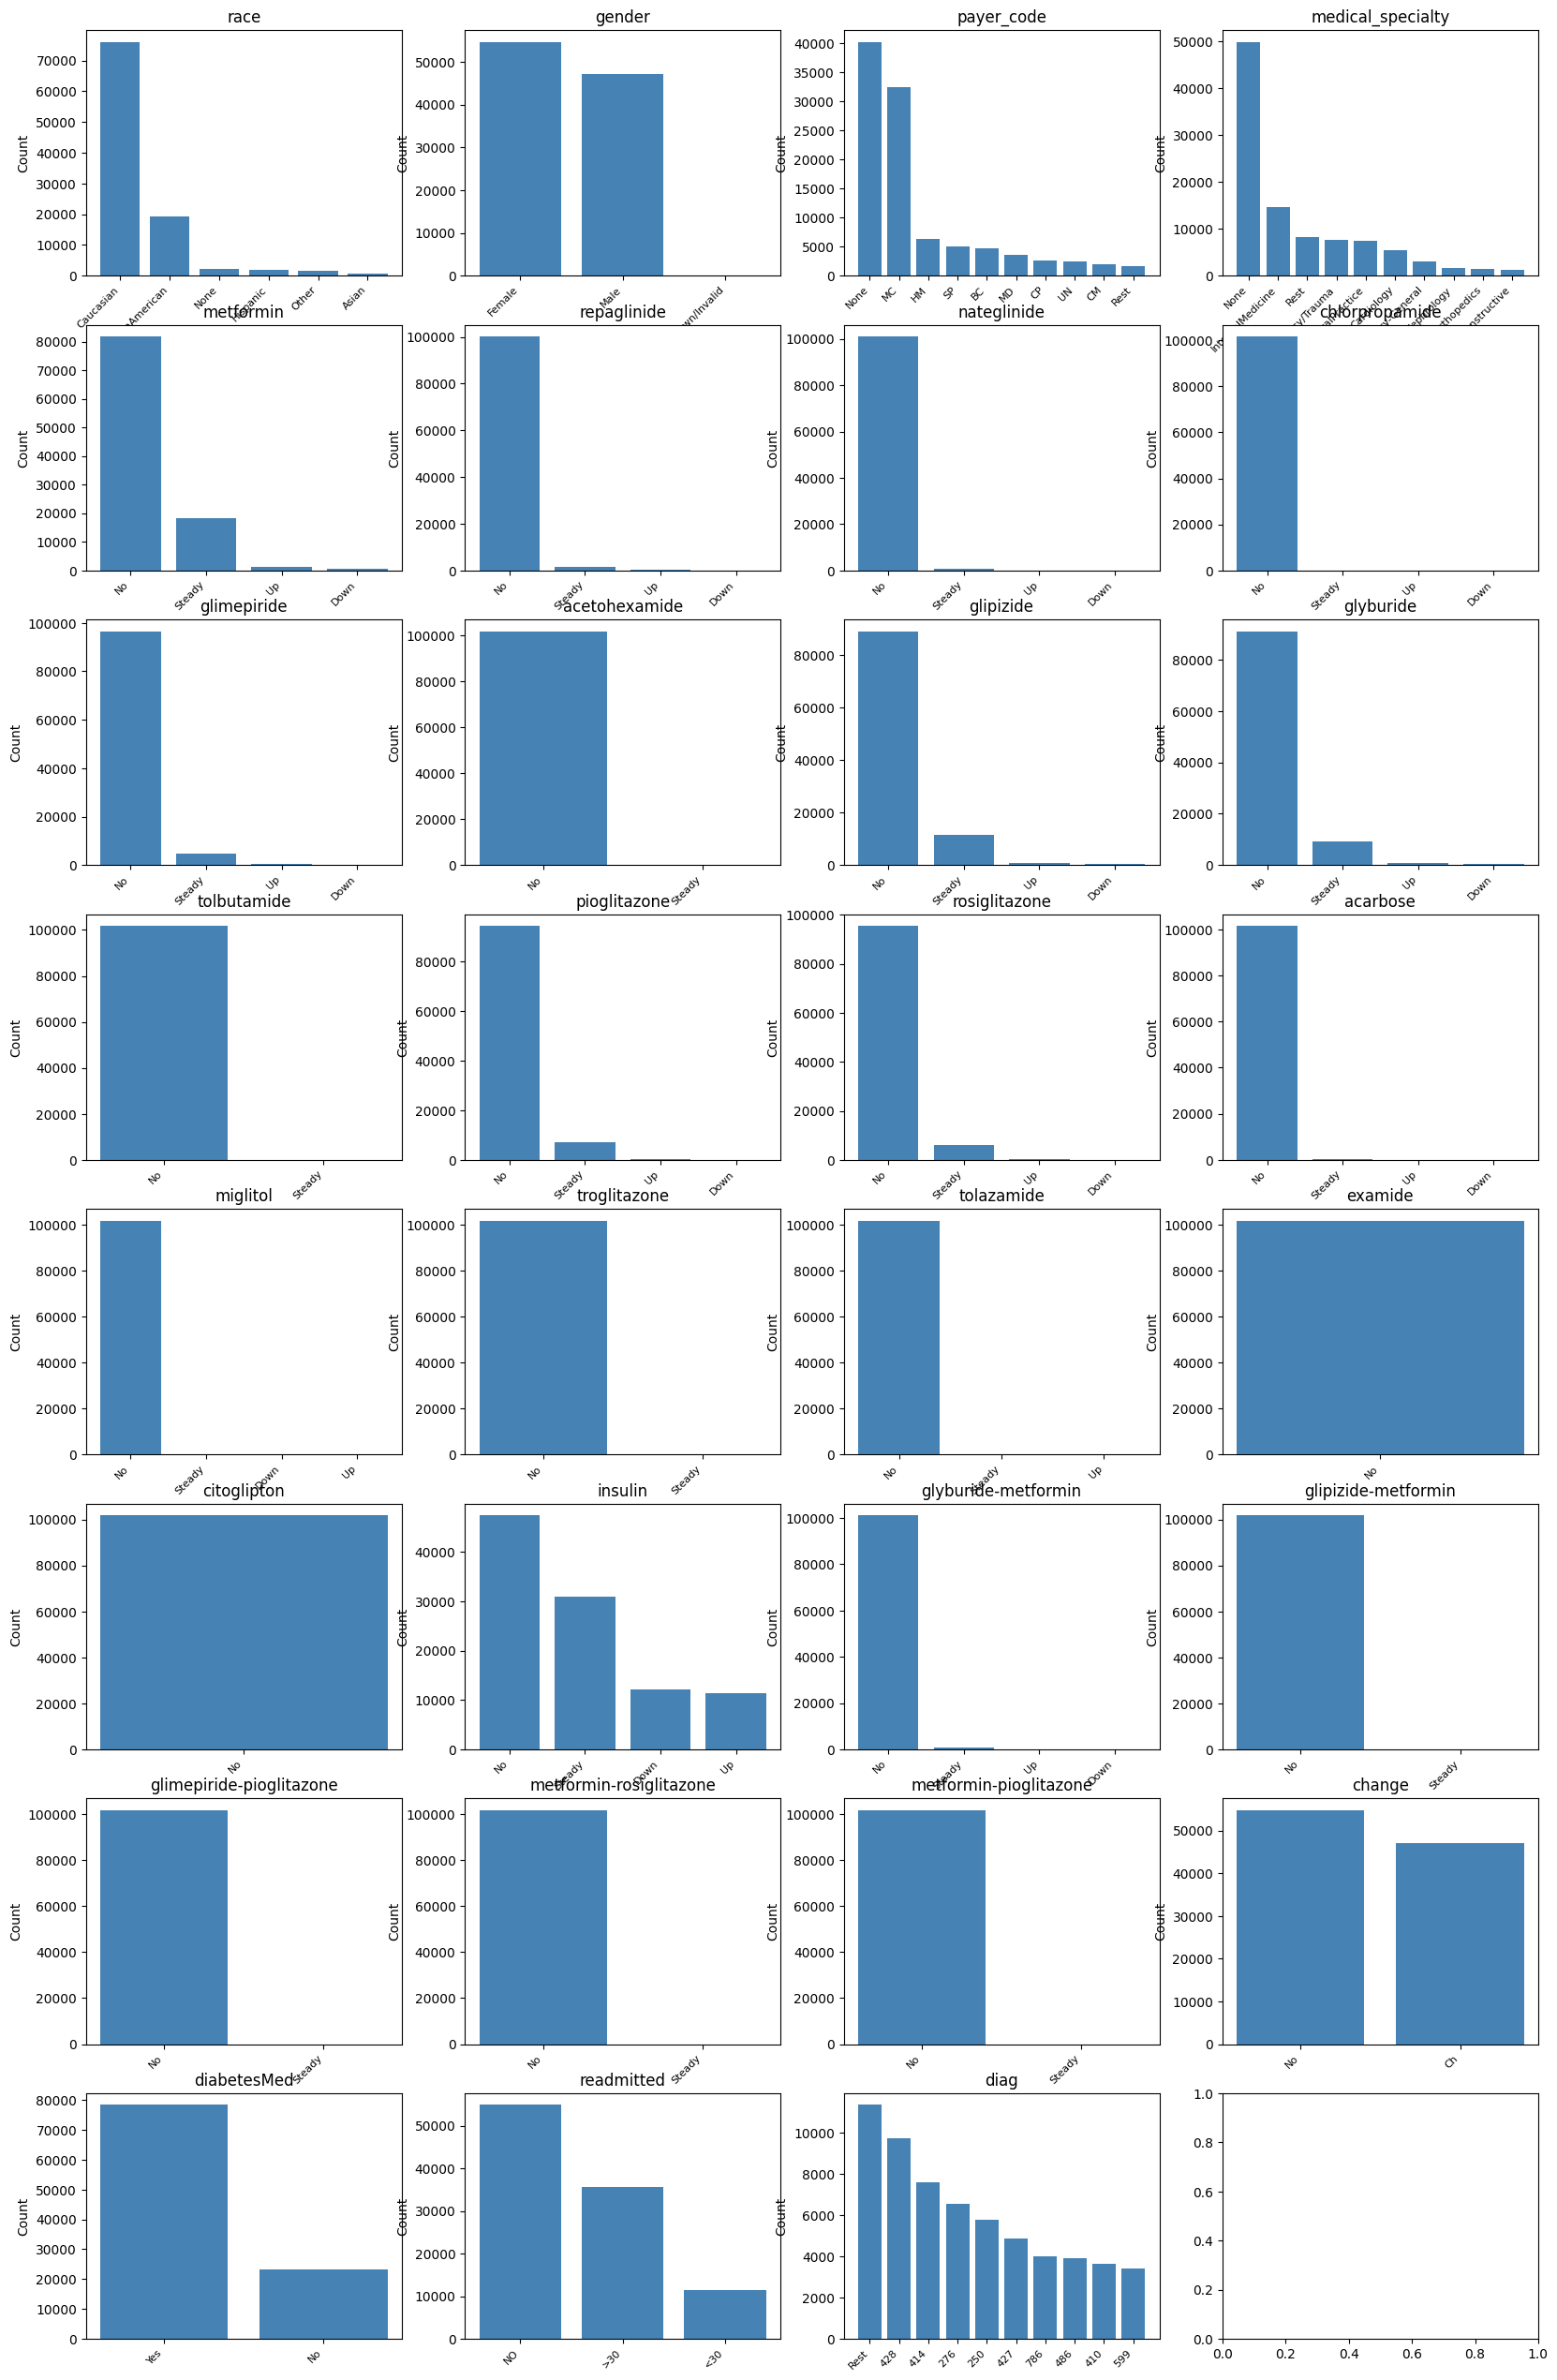

In [194]:
fig, axes = plt.subplots(8, 4, figsize=(20, 32))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through categorical variables
for i, col in enumerate(cat_cols):
    if i < len(axes):  # Safety check
        # Get value counts
        val_counts = df[col].value_counts().nlargest(10)  # Top 10 categories
        
        # Plot bar chart on the corresponding subplot
        bars = axes[i].bar(
            val_counts.index, 
            val_counts.values,
            color='steelblue'
        )
        
        # Add labels
        axes[i].set_title(f'{col}')
        axes[i].set_ylabel('Count')
        
        # Rotate x-labels if needed
        plt.sca(axes[i])
        plt.xticks(rotation=45, ha='right', fontsize=8)
